In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [2]:
def load_data(data_path):
    """
    Method given with the assignment
    """
    FEATURES = range(2, 33)
    N_TIME_SERIES = 3500

    # Create the training and testing samples
    LS_path = os.path.join(data_path, 'LS')
    TS_path = os.path.join(data_path, 'TS')
    X_train, X_test = [np.zeros((N_TIME_SERIES, (len(FEATURES) * 512))) for i in range(2)]

    for f in FEATURES:
        data = np.loadtxt(os.path.join(LS_path, 'LS_sensor_{}.txt'.format(f)))
        X_train[:, (f-2)*512:(f-2+1)*512] = data
        data = np.loadtxt(os.path.join(TS_path, 'TS_sensor_{}.txt'.format(f)))
        X_test[:, (f-2)*512:(f-2+1)*512] = data
    
    y_train = np.loadtxt(os.path.join(LS_path, 'activity_Id.txt'))

    print('X_train size: {}.'.format(X_train.shape))
    print('y_train size: {}.'.format(y_train.shape))
    print('X_test size: {}.'.format(X_test.shape))

    return X_train, y_train, X_test

In [3]:
def write_submission(y, where, submission_name='toy_submission.csv'):

    os.makedirs(where, exist_ok=True)

    SUBMISSION_PATH = os.path.join(where, submission_name)
    if os.path.exists(SUBMISSION_PATH):
        os.remove(SUBMISSION_PATH)

    y = y.astype(int)
    outputs = np.unique(y)

    # Verify conditions on the predictions
    if np.max(outputs) > 14:
        raise ValueError('Class {} does not exist.'.format(np.max(outputs)))
    if np.min(outputs) < 1:
        raise ValueError('Class {} does not exist.'.format(np.min(outputs)))
    
    # Write submission file
    with open(SUBMISSION_PATH, 'a') as file:
        n_samples = len(y)
        if n_samples != 3500:
            raise ValueError('Check the number of predicted values.')

        file.write('Id,Prediction\n')

        for n, i in enumerate(y):
            file.write('{},{}\n'.format(n+1, int(i)))

    print('Submission {} saved in {}.'.format(submission_name, SUBMISSION_PATH))


In [4]:
X_train, y_train, X_test = load_data('data')

X_train size: (3500, 15872).
y_train size: (3500,).
X_test size: (3500, 15872).


Decision tree with min_sample_split = 50 evaluated with 10-CV

In [5]:
clfDT50 = DecisionTreeClassifier(min_samples_split=50)
scoresDT50 = cross_val_score(clfDT50, X_train, y_train, cv=10, n_jobs=-1, error_score='raise')
print(scoresDT50.mean())

0.7725714285714285


Study the accuracy of DT based on the value of min_sample_split

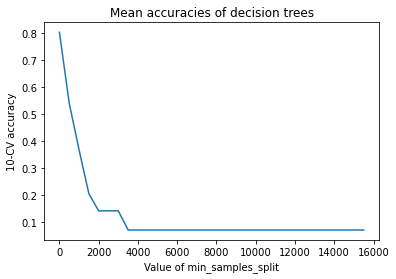

In [5]:
mss = []
accuracies = []
for i in range(5, 15871, 500):
    mss.append(i)
    clf = DecisionTreeClassifier(min_samples_split=i)
    scores = cross_val_score(clf, X_train, y_train, cv=10, n_jobs=-1)
    accuracies.append(scores.mean())
plt.plot(mss, accuracies)
plt.title("Mean accuracies of decision trees")
plt.xlabel("Value of min_samples_split")
plt.ylabel("10-CV accuracy")
plt.savefig("dt_basic_accuracies_1.png")
plt.show()

Based on this first study, we can see that the value of min_sample_split that provides the highest accuracy is lower than 2000.
Let us do a more precise study.

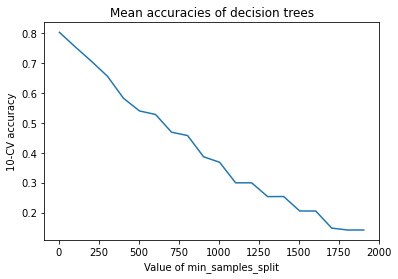

In [7]:
mss = []
accuracies = []
for i in range(5, 2000, 100):
    mss.append(i)
    clf = DecisionTreeClassifier(min_samples_split=i)
    scores = cross_val_score(clf, X_train, y_train, cv=10, n_jobs=-1)
    accuracies.append(scores.mean())
plt.plot(mss, accuracies)
plt.title("Mean accuracies of decision trees")
plt.xlabel("Value of min_samples_split")
plt.ylabel("10-CV accuracy")
plt.savefig("dt_basic_accuracies_2.png")
plt.show()

Based on this second study, we can see that the value of min sample_split that provides the highest accuracy is lower than 250. Let us do a more precise study.

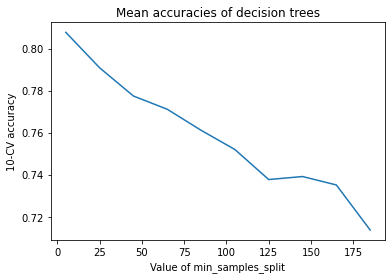

In [9]:
mss = []
accuracies = []
for i in range(5, 200, 20):
    mss.append(i)
    clf = DecisionTreeClassifier(min_samples_split=i)
    scores = cross_val_score(clf, X_train, y_train, cv=10, n_jobs=-1)
    accuracies.append(scores.mean())
plt.plot(mss, accuracies)
plt.title("Mean accuracies of decision trees")
plt.xlabel("Value of min_samples_split")
plt.ylabel("10-CV accuracy")
plt.savefig("dt_basic_accuracies_3.png")
plt.show()

Let us do another study for values of min_sample_split between 1 and 25

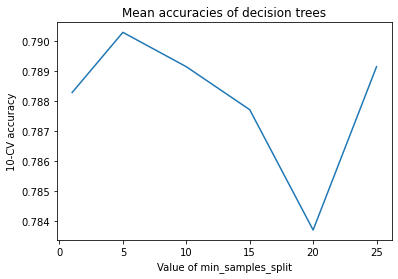

In [13]:
mss = [1, 5, 10, 15, 20, 25]
accuracies = []
for val in mss:
    clf = DecisionTreeClassifier(min_samples_split=i)
    scores = cross_val_score(clf, X_train, y_train, cv=10, n_jobs=-1)
    accuracies.append(scores.mean())
plt.plot(mss, accuracies)
plt.title("Mean accuracies of decision trees")
plt.xlabel("Value of min_samples_split")
plt.ylabel("10-CV accuracy")
plt.savefig("dt_basic_accuracies_4.png")
plt.show()

Let us study what happens precisely in the range [1,5]

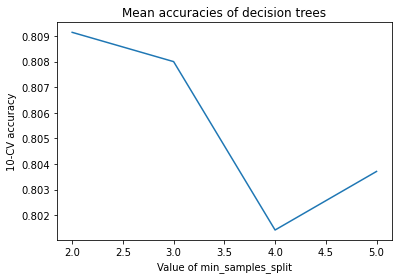

In [15]:
mss = []
accuracies = []
for i in range(1,6,1):
    mss.append(i)
    clf = DecisionTreeClassifier(min_samples_split=i)
    scores = cross_val_score(clf, X_train, y_train, cv=10, n_jobs=-1)
    accuracies.append(scores.mean())
plt.plot(mss, accuracies)
plt.title("Mean accuracies of decision trees")
plt.xlabel("Value of min_samples_split")
plt.ylabel("10-CV accuracy")
plt.savefig("dt_basic_accuracies_5.png")
plt.show()

Using a small value for min_samples_split seems to provide the best accuracy using a 10-CV.
But, we migh overfit on unseen data. Let us study the overfitting.

In [16]:
xtrain, xtest, ytrain, ytest = train_test_split(X_train, y_train, test_size=0.8, random_state=42)

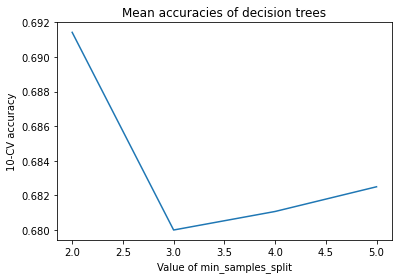

In [19]:
mss = []
accuracies = []
for i in range(2,6,1):
    mss.append(i)
    clf = DecisionTreeClassifier(min_samples_split=i).fit(xtrain, ytrain)
    score = clf.score(xtest, ytest)
    accuracies.append(score)
plt.plot(mss, accuracies)
plt.title("Mean accuracies of decision trees")
plt.xlabel("Value of min_samples_split")
plt.ylabel("10-CV accuracy")
plt.savefig("dt_basic_accuracies_5.png")
plt.show()

Let us use minimal cost-complexity prunning.
Based on https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#

In [21]:
xtrain, xtest, ytrain, ytest = train_test_split(X_train, y_train, random_state=42)

In [22]:
tree = DecisionTreeClassifier(random_state=42)
path = tree.cost_complexity_pruning_path(xtrain, ytrain)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [ ]:
print(ccp_alphas)
print(len(ccp_alphas))

In [ ]:
trees = []
for ccp_alpha in ccp_alphas:
    tree = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    tree.fit(xtrain, ytrain)
    trees.append(tree)

In [ ]:
trees = trees[:-1]
ccp_alphas = ccp_alphas[:-1]

train_scores = [tree.score(X_train, y_train) for tree in trees]
test_scores = [tree.score(X_test, y_test) for tree in trees]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()